In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

# Questions
- What catchment characteristics correlate with places we perform well / badly?
- Any relationship between discharge and soil moisture sims?

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))

In [4]:
from scripts.cell_state.normalize import normalize_cstate

# better normalize c state

if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")

### What do the cell states look like?

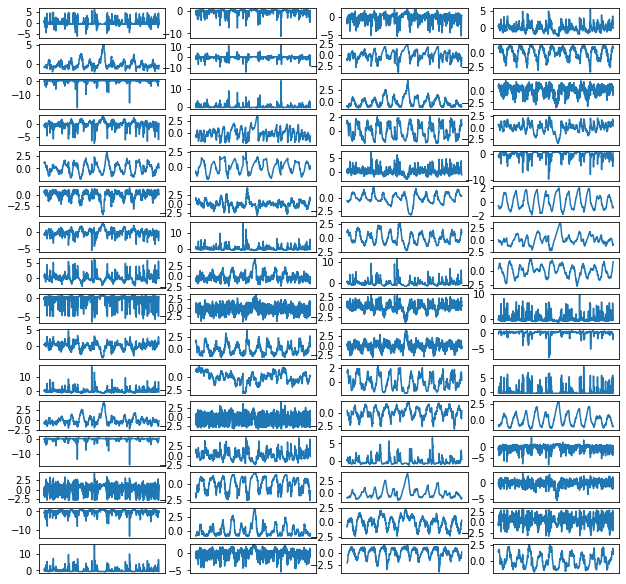

In [5]:
scale = 1.3
N_dims = 64
nrows = int(N_dims / 4)
ncols = 4
f, axs = plt.subplots(nrows, ncols, figsize=(2*scale*ncols, 0.5*scale*nrows))

for ix in range(64):
    ax = axs[np.unravel_index(ix, (nrows, ncols))]
    data = norm_cs_data.isel(dimension=ix, station_id=0).to_dataframe()
    ax.plot(data.index, data["c_n"])
    ax.set_xticklabels([])
    ax.set_xticks([])
    # ax.set_yticklabels([])
    # ax.set_yticks([])

### ESA CCI SM

In [6]:
from scripts.cell_state.normalize import normalize_2d_dataset

filepath = data_dir / "SOIL_MOISTURE/interp_full_timeseries_esa_cci_sm.nc"
esa_ds = xr.open_dataset(filepath).drop("spatial_ref")
if not isinstance(esa_ds, xr.Dataset):
    esa_ds = esa_ds.to_dataset()

for var in esa_ds.data_vars:
    esa_ds[var] = normalize_2d_dataset(esa_ds, variable_str=var, per_basin=True)

Normalising each station: 100%|██████████| 670/670 [00:01<00:00, 610.47it/s]


In [7]:
esa_ds.to_netcdf(data_dir / "SOIL_MOISTURE/FINAL/esa_ds_interpolated_normalised.nc")

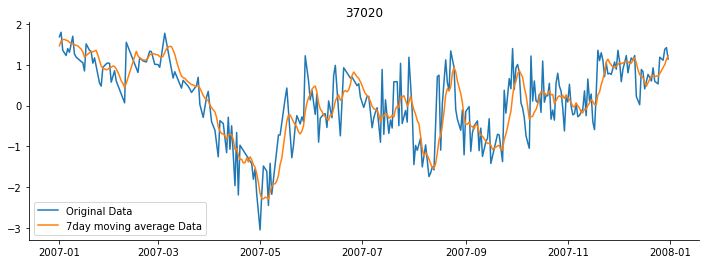

In [8]:
px = np.random.choice(esa_ds.station_id.values)
time = "2007"
f, ax = plt.subplots(figsize=(12, 4))

orig = esa_ds["sm"].sel(time=time, station_id=px)
roll = esa_ds["7_day_smooth_sm"].sel(time=time, station_id=px)
ax.plot(orig.time, orig.values, label="Original Data")
ax.plot(orig.time, roll.values, label="7day moving average Data")
ax.legend()
ax.set_title(px)

sns.despine()

# ERA5Land SM Data

In [9]:
era5filepath = (data_dir / "camels_basin_ERA5Land_sm.nc")
era5_sm = xr.open_dataset(era5filepath)

# CAMELS GB Data

In [10]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))
ds

<xarray.Dataset>
Dimensions:         (station_id: 671, time: 16436)
Coordinates:
  * station_id      (station_id) int64 1001 2001 2002 ... 102001 106001 107001
  * time            (time) datetime64[ns] 1970-10-01 1970-10-02 ... 2015-09-30
Data variables:
    precipitation   (time, station_id) float64 ...
    pet             (time, station_id) float64 ...
    temperature     (time, station_id) float64 ...
    discharge_spec  (time, station_id) float64 ...
    discharge_vol   (time, station_id) float64 ...
    peti            (time, station_id) float64 ...
    humidity        (time, station_id) float64 ...
    shortwave_rad   (time, station_id) float64 ...
    longwave_rad    (time, station_id) float64 ...
    windspeed       (time, station_id) float64 ...

# Analysis

In [11]:
from scripts.cell_state.analysis import calculate_raw_correlations
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

In [12]:
cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

### has the normalisation worked?

In [13]:
from scripts.cell_state.analysis import finite_flat

means = finite_flat(cs.mean(dim="time").to_array().values.flatten())
stds = finite_flat(cs.std(dim="time").to_array().values.flatten())

means_esa = finite_flat(esa_ds.mean(dim="time").to_array().values.flatten())
stds_eas = finite_flat(esa_ds.std(dim="time").to_array().values.flatten())

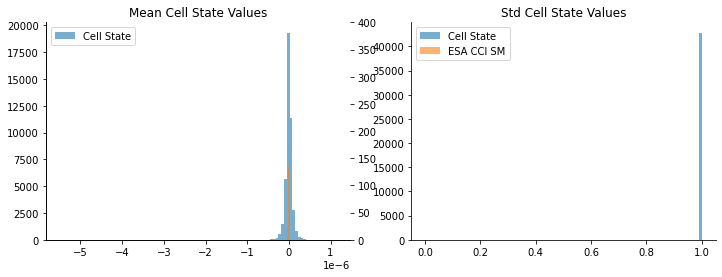

In [14]:
f, axs = plt.subplots(1, 2, figsize=(6*2, 4))
ax = axs[0]
ax.hist(means, bins=100, label="Cell State", alpha=0.6, color="C0");
ax2= ax.twinx()
ax2.hist(means_esa, bins=100, label="ESA CCI SM", alpha=0.6, color="C1");
ax.legend()
ax.set_title("Mean Cell State Values")

ax = axs[1]
ax.hist(stds, bins=100, label="Cell State", alpha=0.6, color="C0");
ax.hist(stds_eas, bins=100, label="ESA CCI SM", alpha=0.6, color="C1");
ax.legend()
ax.set_title("Std Cell State Values")

sns.despine()

# Linear Model

In [15]:
train_start_date = cs.time.min().values
train_end_date = pd.to_datetime("2006-09-30")
test_start_date = pd.to_datetime("2006-10-01")
test_end_date =  cs.time.max().values

input_variables = [v for v in cs.data_vars]

In [16]:
esa_ds.data_vars

Data variables:
    sm               (station_id, time) float32 nan nan nan ... 0.539 -0.1536
    7_day_smooth_sm  (station_id, time) float32 nan nan nan ... -0.5138 -0.3665

In [17]:
TARGET_VAR = "7_day_smooth_sm"

train_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(train_start_date, train_end_date)),
    target_data=esa_ds.sel(time=slice(train_start_date, train_end_date)),
    target_variable=TARGET_VAR,
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Train Samples",
)

test_dataset = TimeSeriesDataset(
    input_data=cs.sel(time=slice(test_start_date, test_end_date)),
    target_data=esa_ds.sel(time=slice(test_start_date, test_end_date)),
    target_variable=TARGET_VAR,
    input_variables=input_variables,
    seq_length=1,
    basin_dim="station_id",
    time_dim="time",
    desc="Creating Test Samples",
)

Creating Test Samples: 100%|██████████| 668/668 [00:05<00:00, 130.45it/s]


In [18]:
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples

X, y, times, station_ids = get_time_basin_aligned_samples(train_dataset)
X_test, y_test, times_test, station_ids_test = get_time_basin_aligned_samples(test_dataset)

Extracting Data: 100%|██████████| 8335/8335 [01:03<00:00, 131.86it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2145/2145 [00:15<00:00, 138.87it/s]


Merging and reshaping arrays


### Calculate raw correlation coefficients...

In [19]:
from tqdm import tqdm

correlations = []
pbar = tqdm(range(X.shape[-1]), desc="Calculating correlations for each dimension")
for i in pbar:
    corr = np.corrcoef(X[:, i], y, rowvar=False)[0, 1]
    correlations.append(corr)
    
correlations = np.array(correlations)

Calculating correlations for each dimension: 100%|██████████| 64/64 [00:02<00:00, 22.24it/s]


In [20]:
from scripts.cell_state.analysis import plot_weights

<AxesSubplot:>

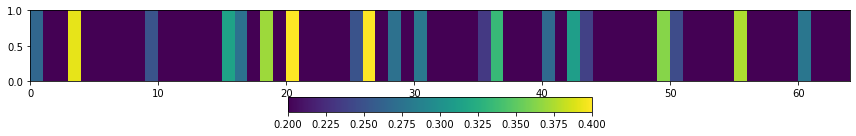

In [21]:
plot_weights(correlations.reshape(1, -1), kwargs={"vmin": 0.2, "vmax": 0.4})

### Elastic net modelling

In [22]:
# from sklearn.linear_model import ElasticNet, ElasticNetCV
# lasso = ElasticNet(
#     l1_ratio=1.0,
#     fit_intercept=True, 
#     normalize=False,
# )

# en = ElasticNet(
#     l1_ratio=0.5,
#     fit_intercept=True, 
#     normalize=False,
# )

# lasso = lasso.fit(X[:1000], y[:1000])
# en = en.fit(X[:1000], y[:1000])

In [23]:
from sklearn.linear_model import SGDRegressor

SEED = 100

np.random.seed(100)

sgd_en = SGDRegressor(
    loss="huber",
    penalty="elasticnet",
    alpha=0.01,
    l1_ratio=0.15,            # default
    fit_intercept=True, 
    n_iter_no_change=10,
    early_stopping=True
)

### Fit the sklearn models

In [24]:
sgd_en.fit(X, y.ravel())

SGDRegressor(alpha=0.01, early_stopping=True, loss='huber', n_iter_no_change=10,
             penalty='elasticnet')

### Predict

In [25]:
y_hat = sgd_en.predict(X_test)

In [26]:
preds_sklearn = pd.DataFrame({
    "station_id": station_ids_test.ravel(),
    "time": times_test.astype("datetime64[ns]").ravel(),
    "obs": y_test.ravel(),
    "sim": y_hat.ravel(),
}).set_index(["station_id", "time"]).to_xarray()

In [27]:
if True:
    y_hat_train = sgd_en.predict(X)
    print("Made Predictions")
    
    train_preds = pd.DataFrame({
        "station_id": station_ids.ravel(),
        "time": times.astype("datetime64[ns]").ravel(),
        "obs": y.ravel(),
        "sim": y_hat_train.ravel(),
    }).set_index(["station_id", "time"]).to_xarray()

Made Predictions


In [28]:
from scripts.read_nh_results import calculate_all_error_metrics

errors_sklearn = calculate_all_error_metrics(
    preds_sklearn,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

train_errors_sklearn = calculate_all_error_metrics(
    train_preds,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="sim",
    metrics=["NSE", "Pearson-r"],
)

Calculating Errors: 100%|██████████| 668/668 [00:07<00:00, 86.03it/s, 106001]


In [29]:
preds_sklearn.to_netcdf(data_dir / "SOIL_MOISTURE/results/sm_sklearn_probe_preds.nc")
errors_sklearn.to_netcdf(data_dir / "SOIL_MOISTURE/results/sm_sklearn_probe_errors.nc")

In [30]:
# nse.median()

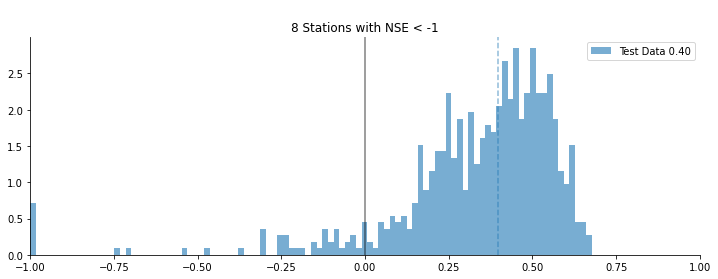

In [53]:
nse = finite_flat(errors_sklearn["NSE"])
nse_train = finite_flat(train_errors_sklearn["NSE"])

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"Test Data {nse.median().values:.2f}", alpha=0.6);
ax.axvline(nse.median(), color="C0", ls="--", alpha=0.5)

# ax.hist(nse_train.where(nse_train > -1, -1), bins=100, density=True, label=f"Train Data {nse_train.median().values:.2f}", alpha=0.6);
# ax.axvline(nse_train.median(), color="C1", ls="--", alpha=0.5)

ax.axvline(0, color="k", ls="-", alpha=0.5)
ax.set_title(f"\n{int((nse < -1).sum())} Stations with NSE < -1")
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

# Create analysis dataset

In [32]:
from scripts.cell_state.timeseries_model import _round_time_to_hour

In [33]:
_x_df = pd.DataFrame(
    {f"dim{i}": X[:, i] for i in range(X.shape[-1])}
)

In [34]:
_df = pd.DataFrame({
    "station_id": station_ids.ravel(), "time": times.astype("datetime64[ns]").ravel(), "y": y.ravel(), 
})

In [35]:
analysis_df = _df.join(_x_df).set_index(["time", "station_id"])
analysis_ds = analysis_df.to_xarray()

In [36]:
from scripts.cell_state.timeseries_model import _round_time_to_hour

analysis_ds["time"] = _round_time_to_hour(analysis_ds["time"].values)

In [37]:
_x_df = pd.DataFrame(
    {f"dim{i}": X_test[:, i] for i in range(X_test.shape[-1])}
)
_df = pd.DataFrame({
    "station_id": station_ids_test.ravel(), "time": times_test.astype("datetime64[ns]").ravel(), "y": y_test.ravel(), 
})
test_analysis_df = _df.join(_x_df).set_index(["time", "station_id"])
test_analysis_ds = test_analysis_df.to_xarray()

In [38]:
analysis_ds = xr.concat([analysis_ds, test_analysis_ds], dim="time")

### how do the forecasts look?

In [39]:
px = np.random.choice(preds_sklearn["station_id"].values)
px = 53013
time_str = "2007"

# select station id, time
data = preds_sklearn.sel(station_id=px, time=time_str).to_dataframe()

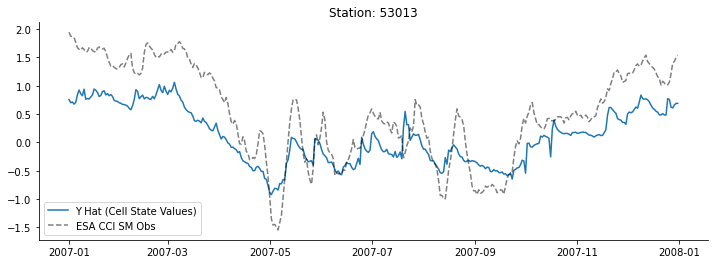

In [40]:
f, ax = plt.subplots(figsize=(12, 4))
ax.plot(data.index, data["sim"], label="Y Hat (Cell State Values)")
ax.plot(data.index, data["obs"], alpha=0.5, color="k", ls="--", label="ESA CCI SM Obs")
ax.set_title(f"Station: {px}")
ax.legend()
sns.despine()

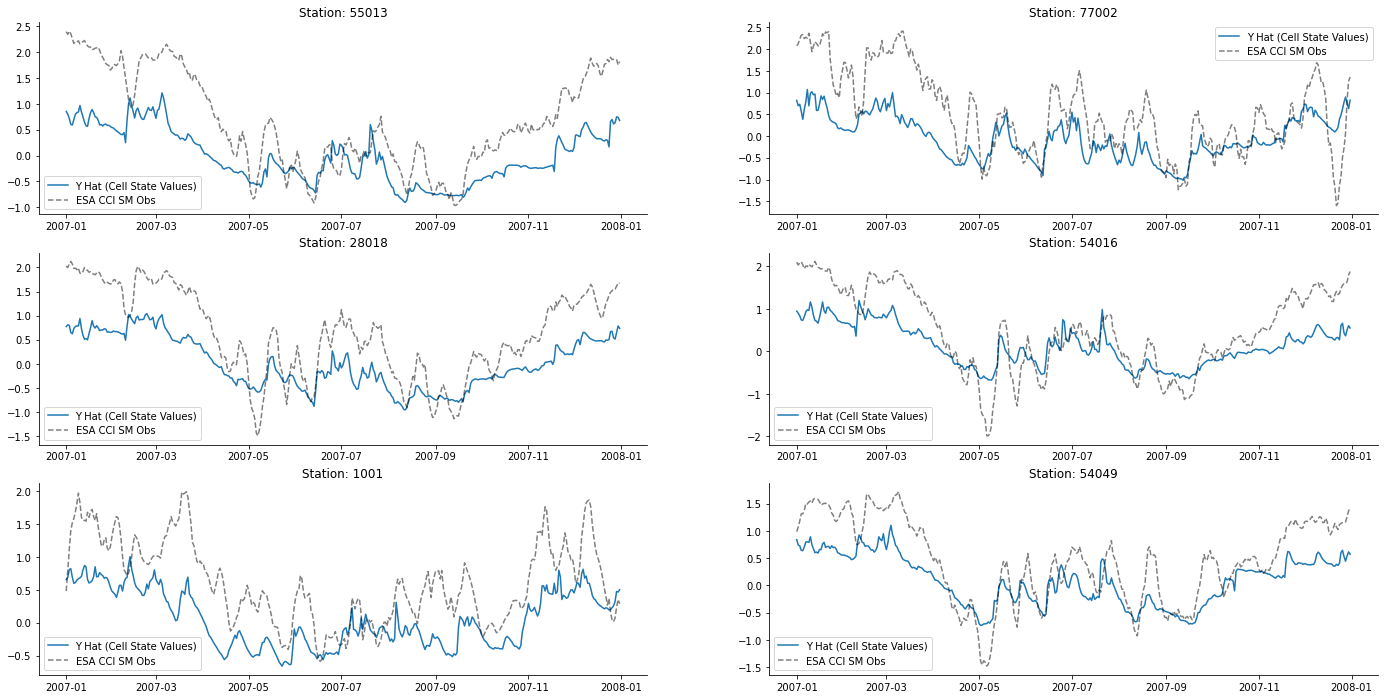

In [55]:
pixels = np.random.choice(preds_sklearn.station_id.values, 6)
f, axs = plt.subplots(3, 2, figsize=(12*2, 4*3))

for ix, px in enumerate(pixels):
    ax = axs[np.unravel_index(ix, (3, 2))]
    data = preds_sklearn.sel(station_id=px, time=time_str).to_dataframe()
    ax.plot(data.index, data["sim"], label="Y Hat (Cell State Values)")
    ax.plot(data.index, data["obs"], alpha=0.5, color="k", ls="--", label="ESA CCI SM Obs")
    ax.set_title(f"Station: {px}")
    ax.legend()
    sns.despine()

# What Do the weights look like??

In [41]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

<AxesSubplot:>

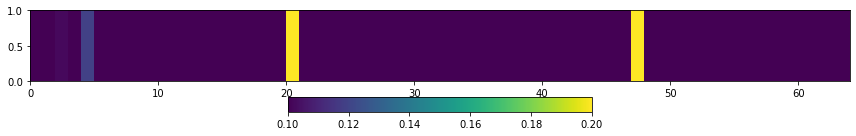

In [42]:
w, b = get_model_weights(sgd_en)

plot_weights(np.abs(w), kwargs={"vmin": 0.1, "vmax": 0.2})

In [57]:
max_idx = np.argmax(np.abs(w))
n = 2
largest_n = np.abs(w).argsort()[-n:][::-1]
feature = f"dim{max_idx}"

features = [f"dim{idx}" for idx in largest_n]
assert feature in analysis_ds.data_vars

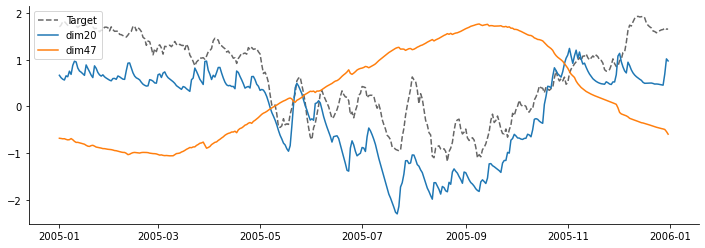

In [58]:
time = "2005"
px = 53013
# px = np.random.choice(analysis_ds.station_id.values)

f, ax = plt.subplots(figsize=(12, 4))
data = analysis_ds.sel(station_id=px, time=time).to_dataframe()
ax.plot(data.index, data["y"], label="Target", color="k", ls="--", alpha=0.6)
ax.legend(loc="upper right")

# ax2 = ax.twinx()
for ix, feature in enumerate(features):  # features  ["dim20"]
    ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}")
    ax.legend(loc="upper left")

sns.despine()

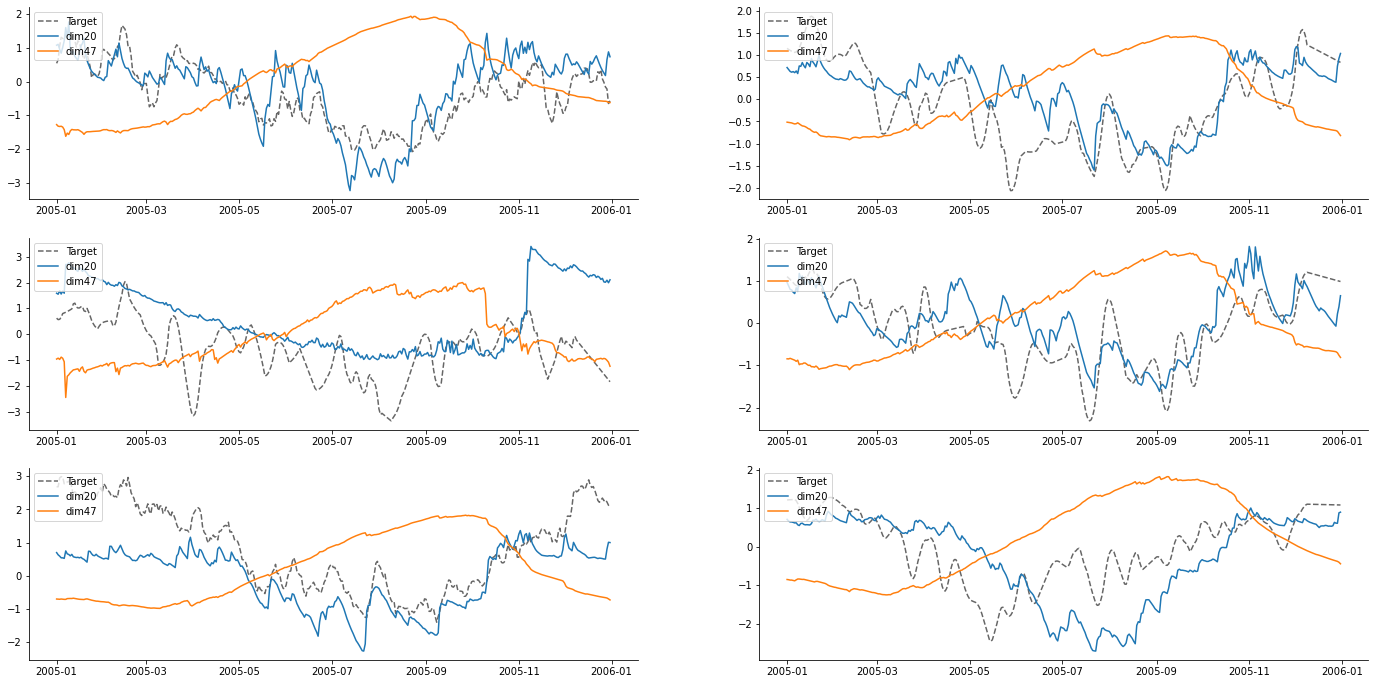

In [59]:
pixels = np.random.choice(preds_sklearn.station_id.values, 6)
f, axs = plt.subplots(3, 2, figsize=(12*2, 4*3))

for ix, px in enumerate(pixels):
    ax = axs[np.unravel_index(ix, (3, 2))]
    data = analysis_ds.sel(station_id=px, time=time).to_dataframe()
    ax.plot(data.index, data["y"], label="Target", color="k", ls="--", alpha=0.6)
    ax.legend(loc="upper right")

    # ax2 = ax.twinx()
    for ix, feature in enumerate(features):  # features  ["dim20"]
        ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}")
        ax.legend(loc="upper left")

    sns.despine()

### How good is just that dimension at predicting?

In [45]:
_pred = pd.DataFrame(
    dict(dim20=X[:, 20], obs=y.ravel(), station_id=station_ids.ravel(), time=times.ravel().astype("datetime64[ns]"))
).set_index(["station_id", "time"]).to_xarray()

In [46]:
_err = calculate_all_error_metrics(
    _pred,
    basin_coord="station_id",
    time_coord="time",
    obs_var="obs",
    sim_var="dim20",
    metrics=["NSE", "Pearson-r"],
)

Calculating Errors: 100%|██████████| 668/668 [00:07<00:00, 85.76it/s, 106001]


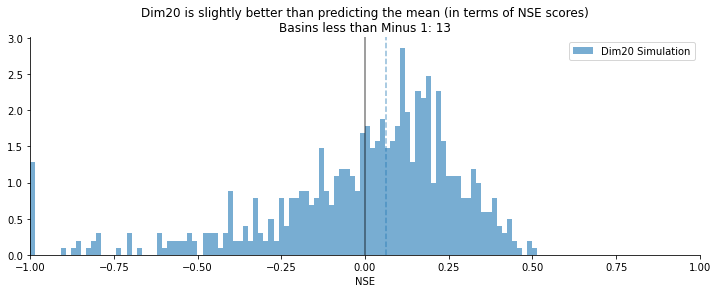

In [47]:
dim20_nse = finite_flat(_err["NSE"])
nse = finite_flat(errors_sklearn["NSE"])
nse_train = finite_flat(train_errors_sklearn["NSE"])

# how many less than -1 ?
n_less_than_minus_1 = (dim20_nse < -1).sum().values
dim20_nse = dim20_nse.where(dim20_nse > -1, -1)

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(dim20_nse, bins=100, density=True, label="Dim20 Simulation", alpha=0.6, color="C0");
ax.axvline(dim20_nse.median(), color="C0", ls="--", alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlim(-1, 1)

ax.axvline(0, color="k", ls="-", alpha=0.5)
ax.set_title(f"Dim20 is slightly better than predicting the mean (in terms of NSE scores)\nBasins less than Minus 1: {n_less_than_minus_1}")
ax.set_xlabel("NSE")
sns.despine()

### is this consistent for the test period?

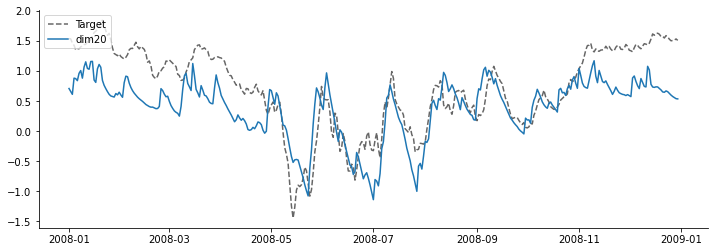

In [48]:
time = "2008"
px = 53013

f, ax = plt.subplots(figsize=(12, 4))
data = analysis_ds.sel(station_id=px, time=time).to_dataframe()
ax.plot(data.index, data["y"], label="Target", color="k", ls="--", alpha=0.6)
ax.legend(loc="upper right")

# ax2 = ax.twinx()
for ix, feature in enumerate(["dim20"]):
    ax.plot(data.index, data[feature], label=f"{feature}", color=f"C{ix}")
    ax.legend(loc="upper left")

sns.despine()

# Which stations have the best soil moisture performance?

In [49]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [50]:
points = load_latlon_points(Path("/home/tommy/spatio_temporal/data"))
gdf = gpd.GeoDataFrame(errors_sklearn["NSE"].to_dataframe().join(points))

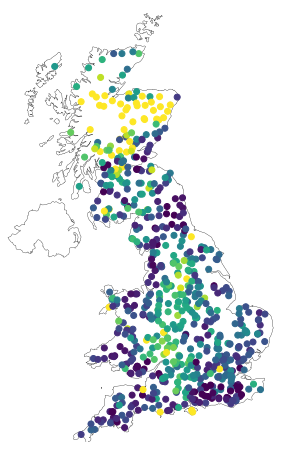

In [51]:
ax = initialise_gb_spatial_plot()

cbar = False
if cbar:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    gdf.plot("NSE", ax=ax, vmin=0, vmax=0.5, cmap="viridis_r", cax=cax, legend=True);
else:
    gdf.plot("NSE", ax=ax, vmin=0, vmax=0.6, cmap="viridis_r")